In [1]:
%reset -s -f

In [2]:
import jax.numpy as np
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('bmh')

In [3]:
numpyro.__version__

'0.2.3'

In [4]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


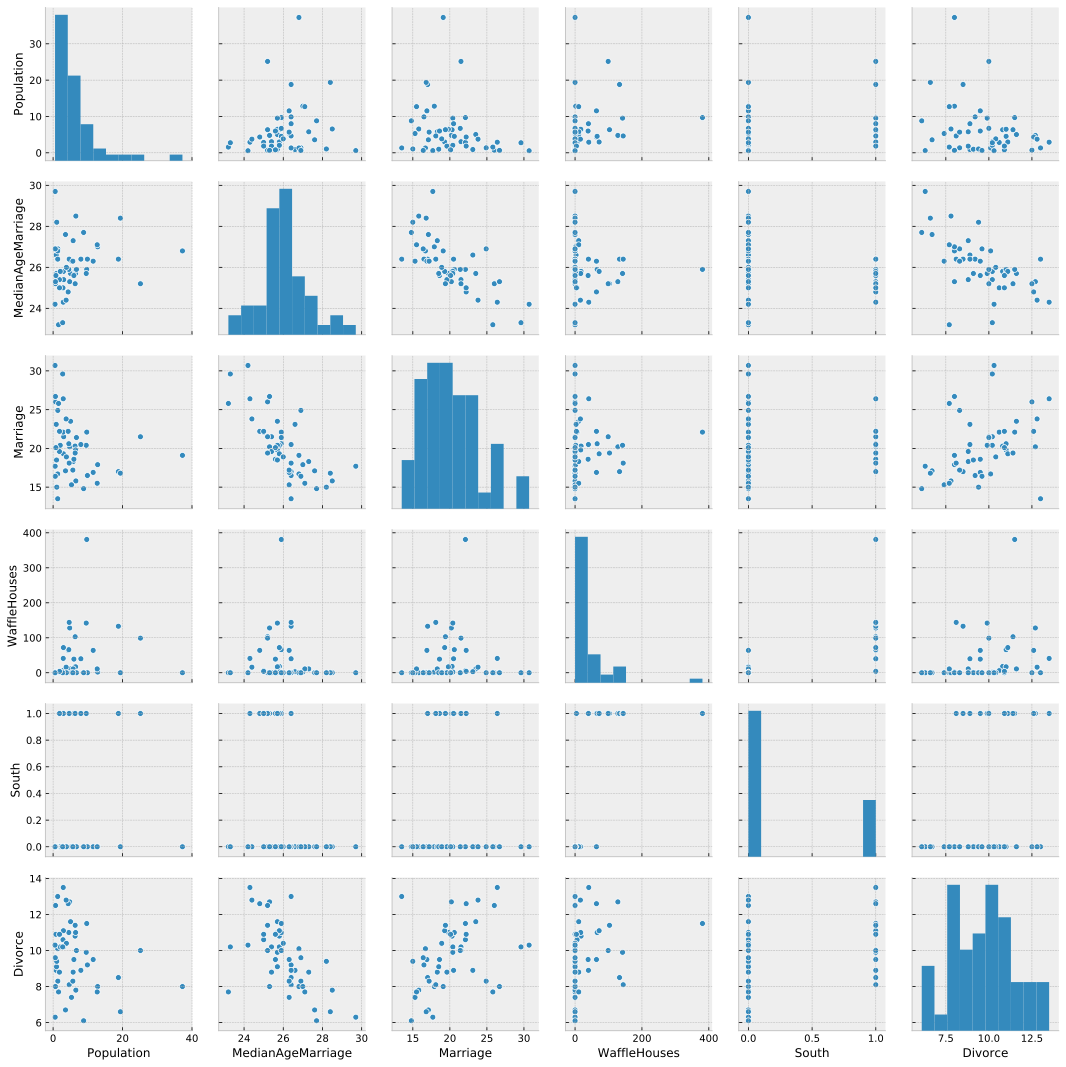

In [5]:
vars = ['Population', 'MedianAgeMarriage', 'Marriage', 'WaffleHouses', 'South', 'Divorce']
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette='husl');

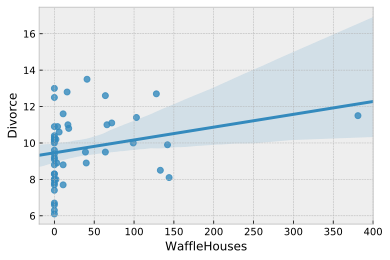

In [6]:
sns.regplot('WaffleHouses', 'Divorce', dset);

In [7]:
standardize = lambda x: (x - x.mean()) / x.std()

dset['AgeScaled'] = dset.MedianAgeMarriage.pipe(standardize)
dset['MarriageScaled'] = dset.Marriage.pipe(standardize)
dset['DivorceScaled'] = dset.Divorce.pipe(standardize)

In [8]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample('a', dist.Normal(0.0, 0.5))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample('bM', dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample('bA', dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

In [9]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 20000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 21000/21000 [00:15<00:00, 1341.13it/s, 3 steps of size 7.15e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.13     -0.00     -0.21      0.21  17369.25      1.00
        bM      0.35      0.13      0.35      0.13      0.56  18914.98      1.00
     sigma      0.95      0.10      0.94      0.78      1.10  16145.69      1.00

Number of divergences: 0


In [10]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

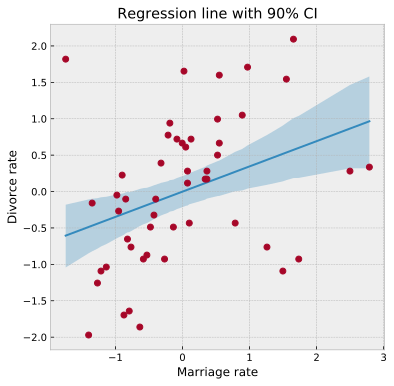

In [11]:
# Compute empirical posterior distribution over mu
posterior_mu = np.expand_dims(samples_1['a'], -1) + \
               np.expand_dims(samples_1['bM'], -1) * dset.MarriageScaled.values

mean_mu = np.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

In [12]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive.get_samples(rng_key_, marriage=dset.MarriageScaled.values)['obs']
df = dset.filter(['Location'])
df['Mean Predictions'] = np.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.013028
1,Alaska,0.534376
2,Arizona,0.009207
3,Arkansas,0.579188
4,California,-0.096325


In [13]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.condition(handlers.seed(model, rng_key), post_samples)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace['obs']['value']

# vectorize predictions via vmap
predict_fn = vmap(lambda rng_key, samples: predict(rng_key, samples, model, marriage=dset.MarriageScaled.values))

In [14]:
# Using the same key as we used for Predictive - note that the results are identical.

predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = np.mean(predictions_1, axis=0)
df = dset.filter(['Location'])
df['Mean Predictions'] = np.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.013028
1,Alaska,0.534376
2,Arizona,0.009207
3,Arkansas,0.579188
4,California,-0.096325


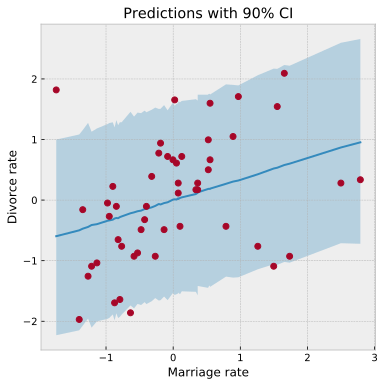

In [15]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Predictions with 90% CI');

In [16]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(handlers.seed(model, rng_key), params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])

def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - np.log(n)).sum()

In [17]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(log_pred_density(rng_key_,
                                                                     samples_1,
                                                                     model,
                                                                     marriage=dset.MarriageScaled.values,
                                                                     divorce=dset.DivorceScaled.values)))

Log posterior predictive density: -66.72642517089844


In [18]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████| 21000/21000 [00:15<00:00, 1395.30it/s, 3 steps of size 6.80e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.12      0.00     -0.18      0.19  18402.50      1.00
        bA     -0.57      0.12     -0.57     -0.76     -0.38  17228.55      1.00
     sigma      0.82      0.09      0.82      0.68      0.96  15756.57      1.00

Number of divergences: 0


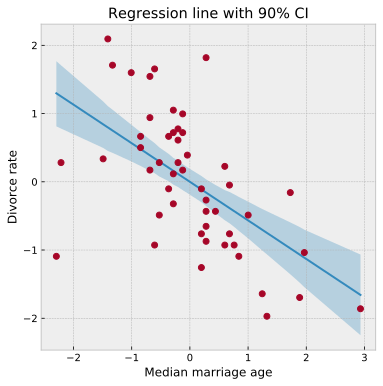

In [19]:
posterior_mu = np.expand_dims(samples_2['a'], -1) + \
               np.expand_dims(samples_2['bA'], -1) * dset.AgeScaled.values
mean_mu = np.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Median marriage age', ylabel='Divorce rate', title='Regression line with 90% CI');

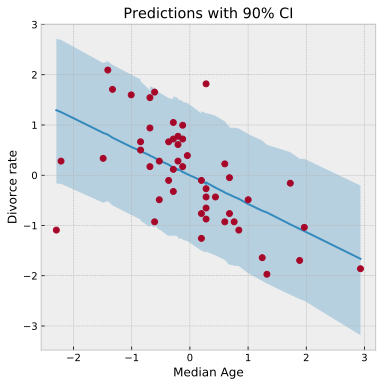

In [20]:
rng_key, rng_key_ = random.split(rng_key)
predictions_2 = Predictive(model, samples_2).get_samples(rng_key_,
                                                         age=dset.AgeScaled.values)['obs']

mean_pred = np.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel='Median Age', ylabel='Divorce rate', title='Predictions with 90% CI');

In [21]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(log_pred_density(rng_key_,
                                                    samples_2,
                                                    model,
                                                    age=dset.AgeScaled.values,
                                                    divorce=dset.DivorceScaled.values)))

Log posterior predictive density: -59.26464080810547


In [22]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, marriage=dset.MarriageScaled.values,
         age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████| 21000/21000 [00:15<00:00, 1363.68it/s, 7 steps of size 6.09e-01. acc. prob=0.90] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.11     -0.00     -0.18      0.20  17072.76      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.34  14334.94      1.00
        bM     -0.06      0.16     -0.06     -0.32      0.20  14428.75      1.00
     sigma      0.83      0.09      0.82      0.69      0.97  15142.08      1.00

Number of divergences: 0


In [23]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(
    log_pred_density(rng_key_,
                     samples_3,
                     model,
                     marriage=dset.MarriageScaled.values,
                     age=dset.AgeScaled.values,
                     divorce=dset.DivorceScaled.values)
))

Log posterior predictive density: -59.09726333618164


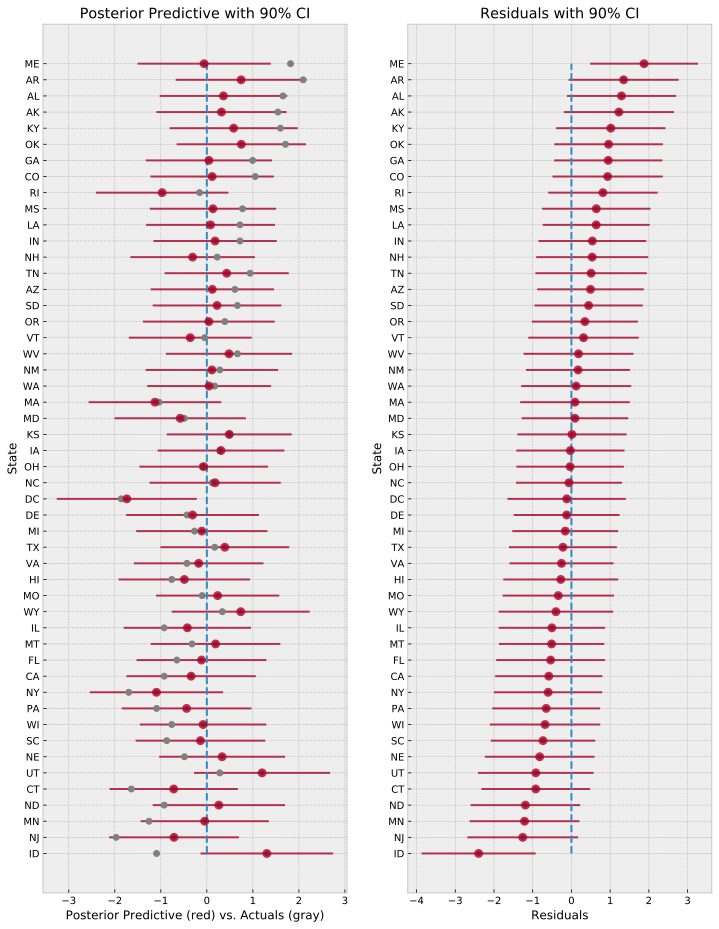

In [24]:
# Predictions for Model 3.
rng_key, rng_key_ = random.split(rng_key)
predictions_3 = Predictive(model, samples_3).get_samples(rng_key_,
                                                         marriage=dset.MarriageScaled.values,
                                                         age=dset.AgeScaled.values)['obs']
y = np.arange(50)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = np.mean(predictions_3, axis=0)
pred_hpdi = hpdi(predictions_3, 0.9)
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = np.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
idx = np.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(np.zeros(50), y, '--')
ax[0].errorbar(pred_mean[idx], y, xerr=pred_hpdi[1, idx] - pred_mean[idx],
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker='o',
           ls='none', color='gray')
ax[0].set(xlabel='Posterior Predictive (red) vs. Actuals (gray)', ylabel='State',
          title='Posterior Predictive with 90% CI')
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10);

# Plot residuals
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = np.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(np.zeros(50), y, '--')
ax[1].errorbar(residuals_mean[idx], y, xerr=err[idx],
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[1].set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10);

In [25]:
def model_se(marriage, age, divorce_sd, divorce=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    bM = numpyro.sample('bM', dist.Normal(0., 0.5))
    M = bM * marriage
    bA = numpyro.sample('bA', dist.Normal(0., 0.5))
    A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    divorce_rate = numpyro.sample('divorce_rate', dist.Normal(mu, sigma))
    numpyro.sample('obs', dist.Normal(divorce_rate, divorce_sd), obs=divorce)

In [26]:
# Standardize
dset['DivorceScaledSD'] = dset['Divorce SE'] / np.std(dset.Divorce.values)

In [27]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_se, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, age=dset.AgeScaled.values,
         divorce_sd=dset.DivorceScaledSD.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_4 = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:10<00:00, 396.72it/s, 15 steps of size 2.93e-01. acc. prob=0.92]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
               a     -0.06      0.10     -0.06     -0.22      0.10   3966.50      1.00
              bA     -0.61      0.16     -0.61     -0.87     -0.36   2557.72      1.00
              bM      0.05      0.17      0.05     -0.23      0.31   2492.16      1.00
 divorce_rate[0]      1.15      0.37      1.15      0.54      1.75   3605.29      1.00
 divorce_rate[1]      0.69      0.54      0.69     -0.16      1.64   5458.77      1.00
 divorce_rate[2]      0.42      0.33      0.42     -0.09      0.97   5768.17      1.00
 divorce_rate[3]      1.41      0.46      1.40      0.68      2.18   4829.59      1.00
 divorce_rate[4]     -0.90      0.13     -0.90     -1.13     -0.70   7228.24      1.00
 divorce_rate[5]      0.65      0.40      0.64     -0.02      1.28   6164.41      1.00
 divorce_rate[6]     -1.36      0.35     -1.36     -1.98     -0.80   6419.94      1.00
 divorce_rate[7]     -0.34      0.49     -

In [28]:
rng_key, rng_key_ = random.split(rng_key)
predictions_4 = Predictive(model_se, samples_4).get_samples(rng_key_,
                                                            marriage=dset.MarriageScaled.values,
                                                            age=dset.AgeScaled.values,
                                                            divorce_sd=dset.DivorceScaledSD.values)['obs']

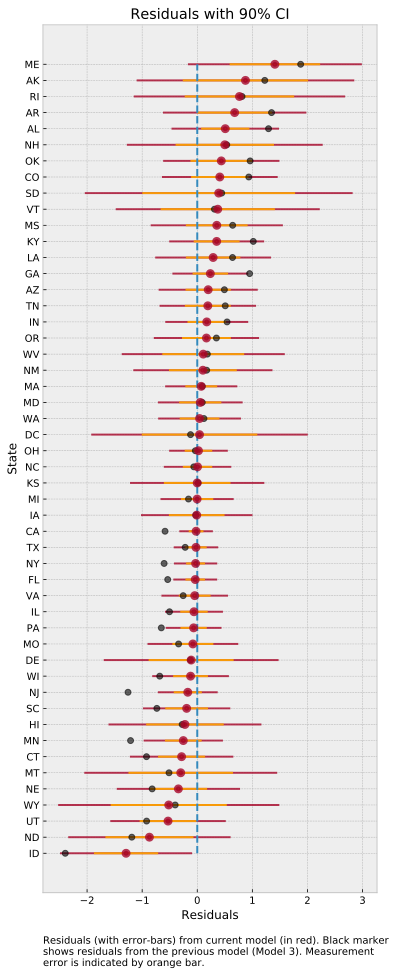

In [29]:
sd = dset.DivorceScaledSD.values
residuals_4 = dset.DivorceScaled.values - predictions_4
residuals_mean = np.mean(residuals_4, axis=0)
residuals_hpdi = hpdi(residuals_4, 0.9)
err = residuals_hpdi[1] - residuals_mean
idx = np.argsort(residuals_mean)
y = np.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 16))


# Plot Residuals
ax.plot(np.zeros(50), y, '--')
ax.errorbar(residuals_mean[idx], y, xerr=err[idx],
            marker='o', ms=5, mew=4, ls='none', alpha=0.8)

# Plot SD
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx],
            ls='none', color='orange', alpha=0.9)

# Plot earlier mean residual
ax.plot(np.mean(dset.DivorceScaled.values - predictions_3, 0)[idx], y,
        ls='none', marker='o', ms=6, color='black', alpha=0.6)

ax.set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax.set_yticks(y)
ax.set_yticklabels(dset.Loc.values[idx], fontsize=10);
ax.text(-2.8, -7, 'Residuals (with error-bars) from current model (in red). '
                  'Black marker \nshows residuals from the previous model (Model 3). '
                  'Measurement \nerror is indicated by orange bar.');

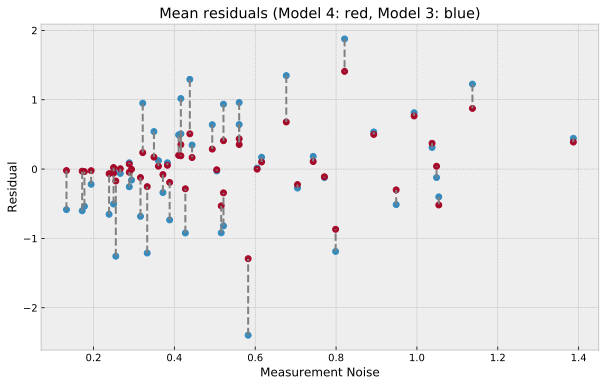

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = dset.DivorceScaledSD.values
y1 = np.mean(residuals_3, 0)
y2 = np.mean(residuals_4, 0)
ax.plot(x, y1, ls='none', marker='o')
ax.plot(x, y2, ls='none', marker='o')
for i, (j, k)  in enumerate(zip(y1, y2)):
    ax.plot([x[i], x[i]], [j, k], '--', color='gray');

ax.set(xlabel='Measurement Noise', ylabel='Residual', title='Mean residuals (Model 4: red, Model 3: blue)');